<img src = "https://drive.google.com/uc?export=view&id=1z-EW8gVlIg4Zcp_HvN-BElP0KknNnfML" alt = "Encabezado MLDS" width = "100%">  </img>

# **Tarea 3: Aprendizaje supervisado: métodos de clasificación**
---

En esta  tarea practicará las habilidades adquiridas aplicando métodos de clasificación y regresión. En el primer ejercicio utilizaremos el *dataset* **digits** de dígitos escritos a mano usando las utilidades de carga de *Scikit-Learn*. En el segundo ejercicio utilizaremos el [*dataset sunspots* de manchas solares observadas mensualmente](https://machinelearningmastery.com/time-series-datasets-for-machine-learning/) obtenido de *Machine Learning Mastery* y atribuido a Andrews & Herzberg.

> **Nota:** Esta tarea va a ser calificada en la plataforma **[UNCode](https://juezun.github.io/)**. Para esto, en cada ejercicio se indicará si es calificable o no, también los lugares donde debe escribir su código sin modificar lo demás con un aproximado de cantidad de líneas a escribir. No se preocupe si su código toma más líneas, esto es simplemente un aproximado destinado a que pueda replantear su estrategia si el código está tomando más de las esperadas. No es un requisito estricto y soluciones más largas también son válidas. Al finalizar, para realizar el envío (*submission*), descargue el notebook como un archivo **`.ipynb`** y haga su entrega a través de **Moodle**.
>
> **La tarea es incremental, es recomendable resolver los puntos en orden.**


## **0. Dependencias**
---
Ejecute la siguiente celda para importar las librerías necesarias.

In [ ]:
# Importamos scikit-learn
import sklearn

In [ ]:
# Importar librerías generales
import numpy as np
import pandas as pd

# Ignoramos las advertencias o warnings.
import warnings
warnings.simplefilter(action='ignore')

In [ ]:
#TEST_CELL
# Configuramos el formato por defecto de la
# librería de visualización Matplotlib.
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme()

In [ ]:
#TEST_CELL
!pip install -U plotly
import plotly
import plotly.express as px

In [ ]:
#TEST_CELL
!python --version
print('NumPy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', mpl.__version__)
print('Plotly', plotly.__version__)
print('Scikit-Learn', sklearn.__version__)

Este material fue creado con las siguientes versiones:

* Python: 3.7.10
* NumPy: 1.19.5
* Pandas: 1.1.5
* Matplotlib: 3.2.2
* Plotly: 4.14.3
* Scikit-Learn: 0.22.2.post

## **1. Clasificación de dígitos escritos a mano**
---
Una de las aplicaciones principales del aprendizaje automático es el procesamiento de imágenes en tiempo real. Existen *datasets* como [**MNIST**](http://yann.lecun.com/exdb/mnist/) construidos manualmente con datos clasificados manualmente, preparados para la aplicación de modelos computacionales.

En esta ocasión utilizaremos el *dataset* **`digits`**, un conjunto de datos de "juguete" inspirado en la misma idea, que consiste en observaciones con imágenes de $8$ x $8$ pixeles de dígitos del $0$ al $9$ escritos a mano.

El objetivo de este ejercicio es entrenar un modelo de clasificación supervisado basado en el algoritmo de **árboles de decisión** en donde a partir de una imagen de $8$ x $8$, genere una predicción de un número entero entre $0$ y $9$.

Para cargar el conjunto de datos se utilizará la función **`load_digits`** del módulo **`sklearn.datasets`**.

In [ ]:
#TEST_CELL
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y= True)

X_digits.shape, y_digits.shape

In [ ]:
#TEST_CELL
pd.Series(y_digits).value_counts()

$X$ tiene $64$ características, que corresponden a los $8 \times 8$ pixeles de cada imagen. En este sentido, se considera una fila de la imagen después de la otra, con el píxel $9$ (índice $8$ del *dataset*) siendo el primer pixel de la segunda fila, y así sucesivamente construyendo un vector de una dimensión con la misma regla:

$$index(i, j) = i + 8j$$

Con $i$ siendo el número de la fila y $j$ el de la columna, empezando en $0$.

A continuación, se muestra como al transformar una observación a la forma de $8 \times 8$ (con el método **`reshape`** de *NumPy*) podemos visualizar cada imagen individualmente (usando el método **`imshow`** de *Matplotlib*).

In [ ]:
#IGNORE_CELL
l = 10 # Número de imágenes por lado en la matriz de imágenes

fig, axes = plt.subplots(nrows = l, ncols = l, figsize = (14, 14))

for i in range(l):
  for j in range(l):
    ind =  np.random.randint(X_digits.shape[0]) # Seleccionamos el índice de una imagen al azar
    im = X_digits[i + j*l].reshape((8, 8)) # Retornamos la forma de la observación a dimensión 8x28
    axes[i, j].axis('off')
    axes[i, j].imshow(im, cmap = 'Greys')  # Mostramos en escala de grises cada pixel (enteros de 0 a 255).

A cada una de estas imágenes le corresponde una etiqueta (el número entero que representa) que se busca predecir en $y$. Utilice la siguiente función para visualizar la etiqueta e imagen de una observación dada.

In [ ]:
#TEST_CELL
#@title  { run: "auto" }
#@markdown Con el siguiente *slider* puede variar entre las observaciones una a visualizar. Puede cambiar este valor por un número entre 0 y 1796. Elija el índice del arreglo que desea revisar:
def digits_img(index, X, y):
  im = X[index].reshape((8,8))
  fig = px.imshow(im, title = f'<b>Etiqueta real: {y[index]}</b>', color_continuous_scale= 'dense',
                  labels=dict(x="Fila (i)", y="Columna (j)", color="Tono")
                  )
  fig.update_layout(
    font = {'size': 27},
    title={'x': 0.55, 'y': 0.915, 'xanchor': 'right'}
    )
  fig.show()

# Mostrar la observación n-ésima del dataset con su etiqueta correspondiente.
index = 1353 #@param {type:"slider", min:0, max:1796, step:1}

digits_img(index, X_digits, y_digits)

En este ejercicio usted deberá aplicar la metodología discutida en el curso para entrenar un modelo que prediga el número escrito en la imagen.

### **1.1. Particiones de entrenamiento y prueba de *digits***
---

Antes de continuar y como siempre, es importante definir primero los datos que serán usados para el entrenamiento y los que serán usados para evaluar el modelo.

En este punto deberá implementar la función **`load_digits_train_test`**, que a partir de un número real **`p`** genere una partición de los datos del *dataset* *digits* en datos de entrenamiento (**`X_digits_train`** y **`y_digits_train`**) y de evaluación (**`X_digits_test`** y **`y_digits_test`**), en donde el tamaño del conjunto de entrenamiento corresponda al porcentaje **`p`** del total de datos disponibles.

> **Nota:** La partición debe ser **estratificada** y debe aceptar el parámetro de semilla aleatoria **`seed`**. No se le dará como entrada el conjunto de datos y deberá cargarlo como se mencionó al principio de esta actividad.

**Entrada**:

* **`p`**: número real entre $0$ y $1$ con la proporción correspondiente a la partición de prueba.
* **`seed`**: número real con la semilla aleatoria para la generación de la partición.

**Salida**:
* **`X_train`**: arreglo de *NumPy* con *shape* aproximado $(n\cdot (1-p), m)$ para la partición de entrenamiento de **`X`**.
* **`X_test`**:  arreglo de *NumPy* con *shape* aproximado $(n\cdot p, m)$ para la partición de prueba de **`X`**.
* **`y_train`**: arreglo de *NumPy* con *shape* aproximado $(n \cdot (1-p),)$ para la partición de entrenamiento de **`y`**.
* **`y_test`**:  arreglo de *NumPy* con *shape* aproximado $(n\cdot p,)$ para la partición de prueba de **`y`**.





In [ ]:
# FUNCIÓN CALIFICADA load_digits_train_test:

# Módulo necesario para realizar el ejercicio.
from sklearn import model_selection

def load_digits_train_test(
  # ¡No modifique los valores por defecto de los argumentos!
              p = 0.3, seed = 333):
  """
  Entradas:
    p: proporción de los datos usado para prueba.
    seed: semilla aleatoria para la creación de la partición.
  Retorna:
    X_train: arreglo de NumPy con shape aproximado (n(1 - p), m)
              para la partición de entrenamiento de X.
    X_test:  arreglo de NumPy con shape aproximado (n(p), m)
              para la partición de prueba de X.
    y_train: arreglo de NumPy con shape aproximado (n(1 - p),)
              para la partición de entrenamiento de y.
    y_test:  arreglo de NumPy con shape aproximado (n(p),)
              para la partición de prueba de y.
  """
  ### ESCRIBA SU CÓDIGO AQUÍ ### (~ 2 líneas de código)

  X_train, X_test, y_train, y_test = None, None, None, None

  ### FIN DEL CÓDIGO ###

  return X_train, X_test, y_train, y_test

Ejecute la siguiente celda para probar su código:

In [ ]:
#TEST_CELL
X_digits_train, X_digits_test, y_digits_train, y_digits_test = load_digits_train_test(0.4, 32)

if np.all([isinstance(p, np.ndarray)
          for p in (X_digits_train, X_digits_test, y_digits_train, y_digits_test)]):

  print('I. Partición de entrenamiento:\n')

  print(f"Tamaño de X: {X_digits_train.shape}")
  print(f"Primeros 5 valores de X:")
  print(X_digits_train[:5, :5])

  print(f"Primeros 5 valores de y: {y_digits_train[:5]}")
  print(f"Valores únicos de y:", np.bincount(y_digits_train))

  print('\nII. Partición de prueba:\n')
  print(f"Tamaño de X: {X_digits_test.shape}")

  print(f"Primeros 5 valores de X:")
  print(X_digits_test[:5, :5])
  print(f"Primeros 5 valores de y: {y_digits_test[:5]}")
  print(f"Valores únicos de y:", np.bincount(y_digits_test))
else:
  print("Alguno de los objetos asignado no es un arreglo de NumPy válido.")

**Salida esperada:**
```
I. Partición de entrenamiento:

Tamaño de X: (1078, 64)
Primeros 5 valores de X:
[[ 0.  0.  4. 15. 16.]
 [ 0.  0.  3. 14. 16.]
 [ 0.  0.  7. 16.  9.]
 [ 0.  0.  6. 15. 13.]
 [ 0.  0.  9. 13.  6.]]
Primeros 5 valores de y: [7 7 9 8 9]
Valores únicos de y: [107 109 106 110 109 109 109 107 104 108]

II. Partición de prueba:

Tamaño de X: (719, 64)
Primeros 5 valores de X:
[[ 0.  0. 10. 15.  6.]
 [ 0.  0.  5. 14. 15.]
 [ 0.  0.  5. 11. 16.]
 [ 0.  0.  0.  1. 15.]
 [ 0.  1. 12. 16. 14.]]
Primeros 5 valores de y: [0 8 7 1 3]
Valores únicos de y: [71 73 71 73 72 73 72 72 70 72]
```

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>

    
*  Use el método **`train_test_split`** para generar la partición y cargue el conjunto de datos de **`datasets.load_digits`**. No utilice la variable definida anteriormente pues esa celda es ignorada en la calificación.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>

    
* Recuerde usar los argumentos **`test_size`**, **`stratify`** y **`random_state`** del método **`train_test_split`**.
    



### **1.2. Árbol de decisión por validación cruzada con *Grid Search***
---
En este punto debe implementar la función **`tree_grid_search`** de tal manera que reciba la partición de datos de entrenamiento **`X_train`** y **`y_train`** y entrene el mejor clasificador basado en árboles de decisión, realizando una exploración de hiperparámetros con *grid search*. Además, se le entregará el número de pliegues **`k`** a generar por cada configuración y un diccionario **`param_grid`** con los hiperparámetros a explorar. Para garantizar la reproducibilidad de su resultado, se le entregará además el argumento **`seed`**, que deberá ser usado como semilla aleatoria en el entrenamiento del clasificador (en el constructor del clasificador base).

> **Nota**:
* Por defecto **`GridSearchCV`** usa 5 pliegues para realizar validación cruzada. Para tener más control sobre la validación cruzada se puede utilizar el parámetro **`cv`** para definir el número de pliegues.
* No utilice el argumento **`verbose`** del constructor **`GridSearchCV`**. Hacerlo podría generar problemas en la calificación debidos a la salida de texto.


**Entrada:**

* **`X_train`**: arreglo de *NumPy* de tamaño $(n, m)$ para entrenamiento.
* **`y_train`**: arreglo de *NumPy* de tamaño $(n, )$ para entrenamiento.
* **`param_grid`**: diccionario con las listas de valores posibles de cada hiperparámetro del modelo de árbol de decisión de *Scikit-Learn*.
* **`k`**: número entero del total de pliegues de validación cruzada que se deben explorar en la búsqueda de hiperparámetros.
* **`seed`**: número real con la semilla aleatoria para el entrenamiento de los clasificadores.

**Salida:**

* **`gsearch`**: Objeto **`GridSearchCV`** entrenado con las posibles configuraciones de hiperparámetros **`param_grid`** del árbol de decisión sobre los datos **`X_train`** y **`y_train`**.



In [ ]:
# FUNCIÓN CALIFICADA tree_grid_search:

# Módulos necesarios para realizar el ejercicio.
from sklearn import model_selection
from sklearn import tree

def tree_grid_search(X_train, y_train, param_grid, k,
# ¡No modifique los valores por defecto de los argumentos!
                seed = 333):
  """
  Entradas:
    X_train: Arreglo de NumPy con shape (n, m),
    y_train: Arreglo de NumPy con shape (n,).
    param_grid: Hiperparámetros a explorar.
    k: Número de pliegues de validación cruzada
    seed: semilla aleatoria para la creación de la partición.
  Retorna:
    gsearch: GridSearchCV entrenado con X_train y y_train.
  """
  ### ESCRIBA SU CÓDIGO AQUÍ ### (~ 3-4 líneas de código)

  # Declare el clasificador base del modelo basado en árboles de decisión.
  # IMPORTANTE: Fije la seed aleatoria con el argumento 'random_state'.

  tree_clf = None

  # Declare y entrene el objeto GridSearchCV.
  gsearch = None

  ### FIN DEL CÓDIGO ###

  return gsearch

Definimos la variable **`param_grid`** con la llave **`criterion`** con los valores **`["gini", "entropy"]`** y la llave **`max_depth`** para explorar la profundidad máxima del árbol. Ejecute la siguiente celda para probar su código.

In [ ]:
#TEST_CELL
from sklearn import datasets
param_grid = {
    "max_depth": range(5, 60, 5),     # Profundidad máxima del árbol de decisión.
    "criterion": ["gini", "entropy"], # Criterio de partición del árbol.
  }

X2, y2 = datasets.make_classification(random_state = 123)
gsearch = tree_grid_search(X2, y2, param_grid, k=3)

if gsearch is not None:
  print(f'Mejores hiperparámetros:\n {gsearch.best_params_}')
  print(f'Mejor exactitud (validación): {gsearch.best_score_:.6f}')
else: print('El valor retornado no es un clasificador GridSearchCV válido.')

**Salida esperada**:
```
Mejores hiperparámetros:
 {'criterion': 'entropy', 'max_depth': 5}
Mejor exactitud (validación): 0.920083
```

La siguiente celda realiza la exploración de hiperparámetros para el *dataset* *digits*. Asegurese de obtener el resultado correcto en el ejercicio $1.1$ para obtener una salida apropiada.

In [ ]:
#TEST_CELL
from sklearn import datasets
param_grid = {
    "max_depth": range(5, 60, 5),     # Profundidad máxima del árbol de decisión.
    "criterion": ["gini", "entropy"], # Criterio de partición del árbol.
  }

# Ejercicio 1.1. Cargar los datos de entrenamiento y prueba del dataset digits.
X_digits_train, X_digits_test, y_digits_train, y_digits_test = load_digits_train_test(0.3)
assert np.all([isinstance(p, np.ndarray)
          for p in (X_digits_train, X_digits_test, y_digits_train, y_digits_test)]), "Revise el ejercicio 1.1"

gsearch = tree_grid_search(X_digits_train, y_digits_train, param_grid, k=5)

if gsearch is not None:
  print(f'Mejores hiperparámetros:\n {gsearch.best_params_}')
  print(f'Mejor exactitud (validación): {gsearch.best_score_:.6f}')
else: print('El valor retornado no es un clasificador GridSearchCV válido.')

**Salida esperada**:
```
Mejores hiperparámetros:
 {'criterion': 'entropy', 'max_depth': 10}
Mejor exactitud (validación): 0.864773
```


> **Nota:** una vez tenga una respuesta que le satisfaga, siéntase libre de explorar [otros hiperparámetros](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>

* Use el método **`GridSearchCV`** definiendo la cantidad de pliegues (**`cv`**)y los hiperparámetros a explorar (**`param_grid`**).


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>

* Deberá utilizar un modelo **`DecisionTreeClassifier`** como entrada del objeto **`GridSearchCV`**. No olvide además que deberá fijar la semilla aleatoria **`seed`** en el constructor del árbol de decisión.

### **1.3. Evaluación del desempeño del mejor clasificador**
---

Una vez obtenemos el mejor modelo entrenado tras la exploración de los hiperparámetros, queremos evaluar el desempeño de este desde el punto de vista de distintas métricas.

En este punto tendrá que completar la función **`tree_performance_metrics`**, que deberá retornar las métricas de desempeño de _accuracy_, precisión, _recall y $F_1$ del mejor clasificador encontrado, a partir de los arreglos **`X_test`** y **`y_test`** y la predicción del modelo *grid search*.

> **Nota:** El modelo **`GridSearchCV`** obtiene el mejor estimador con respecto a la métrica por defecto del modelo entrenado (_accuracy_ para clasificación y $R^2$ para regresión). En este ejercicio no tiene que encontrar el mejor estimador por cada tipo de métrica, sino obtener el resultado de la evaluación de desempeño (con las métricas mencionadas) del mejor estimador elegido usando la métrica por defecto, es decir, la exactitud, y retornarlo con el objetivo de contrastar sus valores.

**Entrada:**

* **`gsearch`**: objeto **`GridSearchCV`** entrenado con un modelo de clasificación.
* **`X_test`**: arreglo de *NumPy* de tamaño $(n, m)$ para pruebas.
* **`y_test`**: arreglo de *NumPy* de tamaño $(n, )$ para pruebas.

**Salida:**

* **`accuracy`**: número real, métrica de exactitud del mejor modelo con la partición de prueba.
* **`precision_macro`**: número real, métrica de precisión macro del mejor modelo con la partición de prueba.
* **`recall_macro`**: número real, métrica de _recall_ macro del mejor modelo con la partición de prueba.
* **`f1_macro`**:  número real, métrica $F_1$ *score* macro del mejor modelo con la partición de prueba.


In [ ]:
# FUNCIÓN CALIFICADA tree_performance_metrics:

# Módulos necesarios para realizar el ejercicio.
from sklearn import metrics

def tree_performance_metrics(gsearch, X_test, y_test):
  """
  Entradas:
    gsearch: Modelo entrenado con GridSearchCV
    X_digits_test: Arreglo de numpy con shape (n, m)
    y_digits_test: Arreglo de numpy con shape (n,)
  Retorna:
    accuracy: exactitud en prueba.
    precision_macro: precisión macro en prueba.
    recall_macro: recall macro en prueba.
    f1_macro: f1 score macro en prueba.
  """
  ### ESCRIBA SU CÓDIGO AQUÍ ### (~ 6-7 líneas de código)

  accuracy = None
  precision_macro = None
  recall_macro = None
  f1_macro = None

  ### FIN DEL CÓDIGO ###

  return accuracy, precision_macro, recall_macro, f1_macro

La siguiente celda realiza la evaluación del desempeño del mejor modelo para el *dataset* *digits*. Asegúrese de obtener el resultado correcto en el ejercicio $1.1$ y $1.2$ para obtener una salida apropiada.

In [ ]:
#TEST_CELL
from numbers import Number

# Ejercicio 1.1. Cargar los datos de entrenamiento y prueba del dataset digits.
X_digits_train, X_digits_test, y_digits_train, y_digits_test = load_digits_train_test(0.3)
assert np.all([isinstance(p, np.ndarray)
          for p in (X_digits_train, X_digits_test, y_digits_train, y_digits_test)]), "Revise el ejercicio 1.1"


# Ejercicio 1.2. Entrenar la exploración de hiperparámetros del modelo de árbol de decisión.
param_grid = {
    "max_depth": range(5, 60, 5),     # Profundidad máxima del árbol de decisión.
    "criterion": ["gini", "entropy"], # Criterio de partición del árbol.
  }

gsearch = tree_grid_search(X_digits_train, y_digits_train, param_grid, k=5)
assert isinstance(gsearch, sklearn.model_selection._search.GridSearchCV), "Revise el ejercicio 1.2"


acc, prec, rec, f1 = tree_performance_metrics(gsearch, X_digits_test, y_digits_test)

print(f'Exactitud en prueba: {acc:.6f}' if isinstance(acc, Number) else 'La exactitud no es válida.')
print(f'Precisión macro en prueba: {prec:.6f}' if isinstance(prec, Number) else 'La precisión macro no es válida.')
print(f'Recall macro en prueba: {rec:.6f}' if isinstance(rec, Number) else 'El recall macro no es válido.')
print(f'F1 macro en prueba: {f1:.6f}' if isinstance(f1, Number) else 'El f1 macro no es válido.')

**Salida esperada:**

```
Exactitud en prueba: 0.824074
Precisión macro en prueba: 0.830342
Recall macro en prueba: 0.823599
F1 macro en prueba: 0.825590
```

**Pregunta**:
- ¿Son similares los resultados a aquellos reportados por **`GridSearchCV`** en validación?

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>
<p>

*      Deberá usar las métricas definidas con las funciones **`recall_score`**, **`precision_score`** y **`f1_score`** del módulo **`metrics`**. Para obtener la exactitud puede utilizar el método **`score`** del objeto *grid search* o la función **`accuracy_score`**.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>

* Indique los argumentos de criterio de promedio (**`average`**) de las métricas.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 3</b></font>
</summary>

* Puede realizar la predicción (**`predict`**) o desempeño (**`score`**) del mejor estimador de un objeto **`GridSearchCV`** entrenado utilizando los métodos de forma directa. e.g:

```python
  gsearch.predict(X)
  gsearch.score(X, y)
```


### **1.4. Visualización de los pixeles con mayor importancia**
---
En este problema, dado que cada característica corresponde a uno de los pixeles de las imagenes posibles, es posible que algunos de estos concentren más información, y que encontrar un valor específico en uno de ellos aporte más a tomar una decisión acertada.

Defina la función **`pixel_importances`**, de tal manera que reciba un objeto **`GridSearchCV`** entrenado **`gsearch`** y retorne la importancia de los pixeles en la clasificación de los dígitos en un arreglo de _NumPy_ de tamaño $8 \times 8$, que será usado posteriormente para ilustrar en un mapa de calor la importancia de cada píxel.

**Entrada:**

* **`gsearch`**: objeto **`GridSearchCV`** entrenado con un modelo de clasificación con $64$ características de entrada.

**Salida:**

* **`importances`**: arreglo de *NumPy* de tamaño **`(8, 8)`** con la importancia relativa de cada pixel, obtenida a partir del reporte de importancia por características del objeto **`gsearch`**.

In [ ]:
# FUNCIÓN CALIFICADA pixel_importances:

def pixel_importances(gsearch):
  """
  Entradas:
    gsearch: GridSearchCV entrenado
  Retorna:
    importances: arreglo de numpy con shape(8, 8)
  """
  ### ESCRIBA SU CÓDIGO AQUÍ ### (~ 3-4 líneas de código)

  importances = None

  ### FIN DEL CÓDIGO ###

  return importances

La siguiente celda obtiene el modelo **`GridSearchCV`** de los ejercicios $1$ y $2$. Asegúrese de obtener la respuesta correcta en esos puntos para obtener un resultado apropiado. Ejecute la siguiente celda para ver un mapa de calor con la importancia de los pixeles:

In [ ]:
# TEST_CELL

# Ejercicio 1. Cargar los datos de entrenamiento y prueba del dataset digits.
X_digits_train, X_digits_test, y_digits_train, y_digits_test = load_digits_train_test(0.3)
assert np.all([isinstance(p, np.ndarray)
          for p in (X_digits_train, X_digits_test, y_digits_train, y_digits_test)]), "Revise el ejercicio 1.1"


# Ejercicio 2. Entrenar la exploración de hiperparámetros del modelo de árbol de decisión.
param_grid = {
    "max_depth": range(5, 60, 5),     # Profundidad máxima del árbol de decisión.
    "criterion": ["gini", "entropy"], # Criterio de partición del árbol.
  }
gsearch = tree_grid_search(X_digits_train, y_digits_train, param_grid, k=5)
assert isinstance(gsearch, sklearn.model_selection._search.GridSearchCV), "Revise el ejercicio 1.2"


importances = pixel_importances(gsearch)
if isinstance(importances,np.ndarray):
  if importances.shape == (8, 8):
    plt.figure(dpi = 120)
    sns.heatmap(importances, cmap = 'inferno');
  else:
    print("El arreglo tiene las dimensiones incorrectas.")
    print(f"Tamaño esperado: (8, 8); Tamaño obtenido: {importances.shape}")
else: print("El arreglo retornado no es válido.")

**Salida esperada**

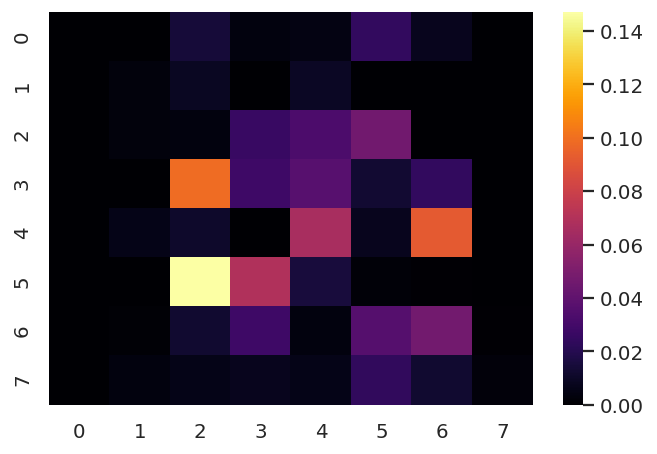

> **Pregunta**:
- ¿Tienen sentido los pixeles con mayor importancia? ¿Qué hay de aquellos con $0$ importancia?

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>

* Obtenga las importancias de cada pixel con el atributo **`feature_importances_`** del mejor estimador del objeto **`GridSearchCV`**.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>


* Utilice la función **`reshape`** de _Numpy_ para cambiar el tamaño del arreglo al tamaño requerido de $(8, 8)$.


## **2. Predicción de la observación de manchas solares**
---

El *dataset* **sunspots** es un registro del número total de observaciones de manchas solares con el paso del tiempo. Los datos usados en esta ocasión consisten en un muestreo mensual del conteo de observaciones registradas. Este archivo proviene de un artículo de *Machine Learning Mastery* y los datos originales están atribuidos a [*Andrews & Herzberg*](https://www2.stat.duke.edu/courses/Spring01/sta114/data/andrews.html).

In [ ]:
#TEST_CELL
!wget -O monthly-sunspots.csv https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv

Cargamos el archivo *csv* con _Pandas_ y exploramos algunos valores.
> **Nota:** No se preocupe por el archivo del *dataset* al enviar su solución, el ambiente de calificación ya tiene este archivo.

In [ ]:
#TEST_CELL
suns_df = pd.read_csv('monthly-sunspots.csv', index_col= 0, parse_dates= True, squeeze=True)
X_suns = suns_df.values

suns_df.head(13)

Podemos observar que el conjunto de datos contiene los datos de $235$ años.

In [ ]:
#TEST_CELL
years = len(suns_df) / 12
print(years)

In [ ]:
#TEST_CELL
suns_df.plot(figsize = (26, 6));

### **2.1. Partición de series de tiempo**
---
Al tratarse de un problema de series de tiempo, vamos a realizar una partición de los datos de tal manera que todos los valores de la partición de pruebas ocurran temporalmente después que los que sean usados en el entrenamiento de nuestro modelo.

Complete la función **`temporal_split`** de tal manera que haga una partición temporal en entrenamiento y prueba del arreglo **`series`** con **`p`** indicando el porcentaje de datos destinados para la partición de prueba.

> **Nota:**
* La partición **NO** es aleatoria, por lo tanto no recibe un parámetro de semilla aleatoria.
* Tenga en cuenta que en este caso el tamaño se aproximará al valor más cercano, es decir, si obtengo que el tamaño para los datos de prueba es $3.6$ lo aproximará a $4$ y si el tamaño para los datos de prueba es $3.4$ se aproximará a $3$.




**Entrada:**

* **`series`**: arreglo de *NumPy* de tamaño $(n, )$ con la serie de tiempo completa.
* **`p`**: número real entre $0$ y $1$ con la proporción correspondiente a la partición de prueba.

**Salida:**

* **`series_train`**: arreglo de *NumPy* de tamaño aproximado $(n(1 - p), )$ con partición de la serie de tiempo para entrenamiento.
* **`series_test`**: arreglo de *NumPy* de tamaño aproximado $(n(p), )$ con partición de la serie de tiempo para pruebas.


In [ ]:
def temporal_split(series, p):
  """
  Entradas:
    series : Arreglo de NumPy con shape (n,) con la serie de tiempo.
    p :porcentaje de datos destinados para la partición de prueba
  Retorna:
    series_train: Arreglo de NumPy con partición de entrenamiento de la serie de tiempo.
    series_test: Arreglo de NumPy con partición de prueba de la serie de tiempo.
  """
  ### ESCRIBA SU CÓDIGO AQUÍ ### (~ 3-4 líneas de código)

  series_train = None
  series_test = None

  ### FIN DEL CÓDIGO ###

  return series_train, series_test

Ejecuta las siguientes celdas para probar su código:

In [ ]:
#TEST_CELL
for p in np.arange(0.3, 1, 0.05):
  print(temporal_split(np.arange(10), p))

**Salida esperada**:

```
(array([0, 1, 2, 3, 4, 5, 6]), array([7, 8, 9]))
(array([0, 1, 2, 3, 4, 5]), array([6, 7, 8, 9]))
(array([0, 1, 2, 3, 4, 5]), array([6, 7, 8, 9]))
(array([0, 1, 2, 3, 4, 5]), array([6, 7, 8, 9]))
(array([0, 1, 2, 3, 4]), array([5, 6, 7, 8, 9]))
(array([0, 1, 2, 3, 4]), array([5, 6, 7, 8, 9]))
(array([0, 1, 2, 3]), array([4, 5, 6, 7, 8, 9]))
(array([0, 1, 2, 3]), array([4, 5, 6, 7, 8, 9]))
(array([0, 1, 2]), array([3, 4, 5, 6, 7, 8, 9]))
(array([0, 1, 2]), array([3, 4, 5, 6, 7, 8, 9]))
(array([0, 1]), array([2, 3, 4, 5, 6, 7, 8, 9]))
(array([0, 1]), array([2, 3, 4, 5, 6, 7, 8, 9]))
(array([0]), array([1, 2, 3, 4, 5, 6, 7, 8, 9]))
(array([0]), array([1, 2, 3, 4, 5, 6, 7, 8, 9]))
```

In [ ]:
#TEST_CELL

X_train, X_test = temporal_split(X_suns, p=0.3)
if isinstance(X_train, np.ndarray) and isinstance(X_test, np.ndarray):
  print(f'Los shapes son: {X_train.shape}, {X_test.shape}')
else: print("Alguno de los arreglos retornados no es válido.")

**Salida esperada**:

```
Los shapes son: (1974,), (846,)
```

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>


* La primera porción de los datos debe pertenecer a la partición de entrenamiento y la segunda a la partición de prueba. Temporalmente, la partición de prueba debe estar en el pasado de la partición de prueba.
    


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>

* Redondee el número de ejemplos que corresponden a las particiones de entrenamiento y prueba y utilícelos como índices de cada subarreglo. Por consistencia, se le recomienda utilizar el método **`round`** de *Python*.




### **2.2. Ventanas temporales en formato `X, y`**
---

Para generar una entrada apropiada para un problema de regresión de series de tiempo necesitamos obtener un arreglo en el formato adecuado, con suficientes características para el entrenamiento que correspondan a valores consecutivos en las posibles ventanas de tiempo del conjunto de entrenamiento.

Complete la función **`temporal_window`** que recibe una serie de tiempo **`series`** y genere una matriz con las ventanas de tiempo de tamaño **`w`** en formato **X, y**.

 > **Nota:** El orden en que retorna las ventanas temporales **es importante**, es decir, la ventana temporal con los primeros elementos de la serie debe estar en la posición **`X[0]`**, de igual manera la serie de tiempo que empiece con el $i$-ésimo elemento de la serie de tiempo debe aparecer en la posición **`X[i]`** y **`y[i]`** debe contener el $(i + w)$-ésimo valor de la serie de tiempo. Tenga que en cuenta que si una serie de tiempo tiene $n$ elementos, el arreglo resultante debe contar con $n - w$ ejemplos.



**Entradas**

- **`series`**: vector de datos, arreglo de *NumPy* de tamaño $n$ con la serie de tiempo.
- **`w`**: número entero con el tamaño de las ventanas temporales del arreglo resultante.

**Salidas**:

- **`X`**: matriz de datos, arreglo de *NumPy* de tamaño $(n - w, w)$ con las **`n - w`** ventanas de tiempo de la serie de tiempo **`series`**.
- **`y`**: vector de datos, arreglo de *NumPy* de tamaño $(n - w,)$ con los **`n - w`** valores siguientes a cada ventana del arreglo **`X`**.


In [ ]:
# FUNCIÓN CALIFICADA temporal_window:

def temporal_window(series, w):
  """
  Entradas:
    series: Arreglo de NumPy con tamaño (n,), una serie de tiempo
    w: Número entero, tamaño de las ventanas de tiempo.
  Retorna:
    X: Arreglo de NumPy con shape(n - w, w), las ventanas temporales.
    y: Arreglo de NumPy con shape(n - w,), el valor siguiente en la serie para cada ventana.
  """
  ### ESCRIBA SU CÓDIGO AQUÍ ### (~ 3-4 líneas de código)

  X, y = None, None

  ### FIN DEL CÓDIGO ###

  return X, y

Ejecute las siguientes celdas para probar su código:

In [ ]:
#TEST_CELL

X2, y2 = temporal_window(np.arange(15), 5)
print("X:\n", X2)
print("y:\n", y2)

**Salida esperada:**

```
X:
 [[ 0.  1.  2.  3.  4.]
 [ 1.  2.  3.  4.  5.]
 [ 2.  3.  4.  5.  6.]
 [ 3.  4.  5.  6.  7.]
 [ 4.  5.  6.  7.  8.]
 [ 5.  6.  7.  8.  9.]
 [ 6.  7.  8.  9. 10.]
 [ 7.  8.  9. 10. 11.]
 [ 8.  9. 10. 11. 12.]
 [ 9. 10. 11. 12. 13.]]
y:
 [ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
```

La siguiente celda genera la partición de datos de prueba y entrenamiento realizada en el ejercicio $2.1$. Asegúrese de tener una respuesta satisfactoria en ese punto para obtener un resultado adecuado.

In [ ]:
#TEST_CELL

# Ejercicio 2.1. Generación de las particiones de prueba y entrenamiento del dataset sunspots.
X_train, X_test = temporal_split(X_suns, p=0.3)
assert isinstance(X_train, np.ndarray) and isinstance(X_test, np.ndarray) , "Revise el ejercicio 2.1"

X_train_window, y_train_window = temporal_window(X_train, 10)
X_test_window, y_test_window = temporal_window(X_test, 10)

if np.all([isinstance(p, np.ndarray) for p in (X_train_window, y_train_window, X_test_window, y_test_window)]):
  print('I. Partición de entrenamiento:\n')
  print(f'El shape de X_train es: {X_train_window.shape}')
  print(f'El shape de y_train es: {y_train_window.shape}')
  print(f'Primeros 5 registros de X_train:\n{X_train_window[:5]}')
  print(f'Primeros 5 registros de y_train:\n{y_train_window[:5]}\n')

  print('\nII. Partición de prueba:\n')
  print(f'El shape de X_test es: {X_test_window.shape}')
  print(f'El shape de y_test es: {y_test_window.shape}')
  print(f'Primeros 5 registros de X_test:\n{X_test_window[:5]}')
  print(f'Primeros 5 registros de y_test:\n{y_test_window[:5]}\n')
else: print("Alguno de los arreglos obtenidos no es válido.")

La salida de la celda anterior debería ser:

```
I. Partición de entrenamiento:

El shape de X_train es: (1964, 10)
El shape de y_train es: (1964,)
Primeros 5 registros de X_train:
[[ 58.   62.6  70.   55.7  85.   83.5  94.8  66.3  75.9  75.5]
 [ 62.6  70.   55.7  85.   83.5  94.8  66.3  75.9  75.5 158.6]
 [ 70.   55.7  85.   83.5  94.8  66.3  75.9  75.5 158.6  85.2]
 [ 55.7  85.   83.5  94.8  66.3  75.9  75.5 158.6  85.2  73.3]
 [ 85.   83.5  94.8  66.3  75.9  75.5 158.6  85.2  73.3  75.9]]
Primeros 5 registros de y_train:
[158.6  85.2  73.3  75.9  89.2]


II. Partición de prueba:

El shape de X_test es: (836, 10)
El shape de y_test es: (836,)
Primeros 5 registros de X_test:
[[ 1.7  0.2  1.2  3.1  0.7  3.8  2.8  2.6  3.1 17.3]
 [ 0.2  1.2  3.1  0.7  3.8  2.8  2.6  3.1 17.3  5.2]
 [ 1.2  3.1  0.7  3.8  2.8  2.6  3.1 17.3  5.2 11.4]
 [ 3.1  0.7  3.8  2.8  2.6  3.1 17.3  5.2 11.4  5.4]
 [ 0.7  3.8  2.8  2.6  3.1 17.3  5.2 11.4  5.4  7.7]]
Primeros 5 registros de y_test:
[ 5.2 11.4  5.4  7.7 12.7]
```

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>

* Estudie la implementación de la función en el taller guiado.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>

* Declare los arreglos vacíos con el tamaño correspondiente con el método **`np.empty`** o similares e itere sobre los valores, generando cada ventana y cada valor siguiente y asignando sus valores a los arreglos iniciales.


### **2.3. Entrenamiento de una red neuronal con GridSearchCV**
---
La preparación de los datos nos permite comenzar con la exploración de los mejores hiperparámetros para el modelo de regresión. En esta ocasión usaremos una red neuronal (perceptrón multicapa) para el entrenamiento, que se deberá realizar sobre los arreglos de la partición de entrenamiento (**`X_train`** y **`y_train`**), con un total de **`k`** divisiones (usando **`TimeSeriesSplit`**) y el diccionario de hiperparámetros **`param_grid`**.

Complete la función **`train_time_series_mlp`** de tal manera que entrene y retorne un objeto **`GridSearchCV`** como resultado de la exploración de hiperparámetros del regresor perceptrón multicapa.  Para garantizar la reproducibilidad de su resultado, se le entregará además el argumento **`seed`**, que deberá ser usado como semilla aleatoria en el entrenamiento del regresor (en el constructor del regresor base).

> **Nota:**
* Asegurese de usar  **`TimeSeriesSplit`** como método para realizar la validación cruzada con **`k`** divisiones.
* No utilice el argumento **`verbose`** del constructor **`GridSearchCV`**. Hacerlo podría generar problemas en la calificación debidos a la salida de texto.


**Entrada:**

* **`X_train`**: arreglo de *NumPy* de tamaño $(n, m)$ para entrenamiento.
* **`y_train`**: arreglo de *NumPy* de tamaño $(n, )$ para entrenamiento.
* **`param_grid`**: diccionario con las listas de valores posibles de cada hiperparámetro del modelo de perceptrón multicapa de *Scikit-Learn*.
* **`k`**: número entero del total de divisiones de validación cruzada (para series de tiempo) que se deben explorar en la búsqueda de hiperparámetros.
* **`seed`**: número real con la semilla aleatoria para el entrenamiento de los regresores.

**Salida:**

* **`gsearch`**: objeto **`GridSearchCV`** entrenado con las posibles configuraciones de hiperparámetros **`param_grid`** del perceptrón multicapa sobre los datos **`X_train`** y **`y_train`**.




In [ ]:
# FUNCIÓN CALIFICADA train_time_series_mlp:

# Módulos necesarios para realizar el ejercicio.
from sklearn import model_selection
from sklearn import neural_network

def train_time_series_mlp(X_train, y_train, param_grid, k,
# ¡No modifique los valores por defecto de los argumentos!
                seed = 30303):
  """
  Entradas:
    X_train: Arreglo de numpy con shape (n, m)
    y_train: Arreglo de numpy con shape (n,)
    param_grid: Hiperparámetros a explorar
    k: Número de divisiones para TimeSeriesSplit.
    seed: Semilla aleatoria para la creación de la partición.
  Retorna:
    gsearch: GridSearchCV entrenado con X_train y y_train.
  """
  ### ESCRIBA SU CÓDIGO AQUÍ ### (~ 3-4 líneas de código)

  # Declare el regresor base del modelo perceptrón multicapa.
  # IMPORTANTE: Fije la seed aleatoria con el argumento 'random_state'.
  mlp = None

  # Declare y entrene el objeto GridSearchCV.
  gsearch = None

  ### FIN DEL CÓDIGO ###
  return None

Ejecute la siguiente celda para probar su código:

> **Nota**: La siguiente celda realiza la exploración de los hiperparámetros con el *dataset* *Sunspots*. Asegúrese de obtener el resultado correcto en el ejercicio $2.1$ y $2.2$ para recibir una salida apropiada.

In [ ]:
#TEST_CELL
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import r2_score

# Ejercicio 2.1. Generación de las particiones de prueba y entrenamiento del dataset sunspots.
X_train, X_test = temporal_split(X_suns, p=0.3)
assert isinstance(X_train, np.ndarray) and isinstance(X_test, np.ndarray) , "Revise el ejercicio 2.1"

# Ejercicio 2.2. Transformación de las series en matrices de ventanas de tiempo.
X_train_window, y_train_window = temporal_window(X_train, 10)
X_test_window, y_test_window = temporal_window(X_test, 10)

assert np.all([isinstance(p, np.ndarray) for p in
               (X_train_window, y_train_window, X_test_window, y_test_window)]), "Revise el ejercicio 2.2"

param_grid = {
    "hidden_layer_sizes": [(20,), (40,), (80)],
    "max_iter": [500], "solver": ["lbfgs"]
  }

gsearch = train_time_series_mlp(X_train_window, y_train_window, param_grid, 3)

if isinstance(gsearch, sklearn.model_selection._search.GridSearchCV):
  check_is_fitted(gsearch, msg = 'El modelo retornado no está entrenado.')
  print(f'El mejor coeficiente de determinación (validación): {gsearch.best_score_:.6f}')
  print(f'Los mejores hiperparámetros encontrados:\n {gsearch.best_params_}')
  y_pred = gsearch.predict(X_test_window)
  print(f'El coeficiente de determinación (partición de prueba): {r2_score(y_test_window, y_pred):.6f}')

else: print("El modelo GridSearchCV obtenido no es válido.")

La salida de la celda anterior debería ser similar a la siguiente:

```
El mejor coeficiente de determinación (validación): 0.746096
Los mejores hiperparámetros encontrados:
 {'hidden_layer_sizes': (20,), 'max_iter': 500, 'solver': 'lbfgs'}
El coeficiente de determinación (partición de prueba): 0.877093
```

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>

* Cree una instancia de **`TimeSeriesSplit`** y defina la cantidad de divisiones con el parámetro **`n_splits`**.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>

* Use la instancia de **`TimeSeriesplit`** como el parámetro **`cv`** de **`GridSearchCV`**.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 3</b></font>
</summary>

* El modelo entrenado con **`GridSearchCV`** debería ser declarado con el constructor **`MLPRegressor`** del paquete **`sklearn.neural_network`**. No olvide definir la semilla aleatoria del constructor con el argumento **`random_state`**.


### **2.4. Predecir el siguiente valor de la serie de tiempo**
---
Con el mejor regresor entrenado podemos empezar a realizar predicciones de los próximos eventos solares. Para esto, utilizamos una ventana de valores previos para indicarle a nuestro regresor el estado previo de la serie de tiempo y poder obtener la predicción del siguiente valor.

En este punto deberá completar la función **`next_value`**, que calcule el siguiente valor dado un modelo entrenado **`model`** y una ventana de datos **`window`**.

> **Pregunta:**
- ¿Qué sucedería si se tratara de predecir con una ventana con tamaño distinto a los datos usados para entrenar el modelo?

**Entrada:**

* **`model`**: modelo de regresión entrenado con $w$ características de entrada.
* **`window`**: arreglo de *NumPy* de tamaño $(w, )$ con la ventana de tiempo previa al resultado esperado.

**Salida:**

* **`next`**: número real, valor predicho por el modelo de regresión **`model`** sobre la ventana **`window`**.








In [ ]:
# FUNCIÓN CALIFICADA train_time_series_mlp:

def next_value(model, window):
  """
  Entradas:
    model: modelo de regresión de Scikit-Learn entrenado.
    window: arreglo de NumPy con shape (w,) donde w es el tamaño de la ventana.
  Retorna:
    next: el valor de la predicción con el siguiente valor a la ventana.
  """
  ### ESCRIBA SU CÓDIGO AQUÍ ### (~ 3-4 líneas de código)

  next = None

  ### FIN DEL CÓDIGO ###
  return next

Ejecute las siguientes celdas para probar su código:

In [ ]:
#TEST_CELL
X4, y4 = sklearn.datasets.make_regression(random_state = 369, n_features = 10)
linear_model = sklearn.linear_model.LinearRegression().fit(X4, y4)
next = next_value(linear_model, np.linspace(0, 10, 10))

print(f'Predicción: {next:.6f}' if isinstance(next, Number) else "El número retornado no es válido.")

**Salida esperada:**
```
Predicción: 2379.117487
```

In [ ]:
#TEST_CELL
from sklearn.utils.validation import check_is_fitted
from numbers import Number

# Ejercicio 2.1. Generación de las particiones de prueba y entrenamiento del dataset sunspots.
X_train, X_test = temporal_split(X_suns, p=0.3)
assert isinstance(X_train, np.ndarray) and isinstance(X_test, np.ndarray) , "Revise el ejercicio 2.1"

# Ejercicio 2.2. Transformación de las series en matrices de ventanas de tiempo.
X_train_window, y_train_window = temporal_window(X_train, 10)
X_test_window, y_test_window = temporal_window(X_test, 10)

assert np.all([isinstance(p, np.ndarray) for p in
               (X_train_window, y_train_window, X_test_window, y_test_window)]), "Revise el ejercicio 2.2"

# Ejercicio 2.3. Entrenamiento del modelo con la búsqueda de la mejor configuración de hiperparámetros.
param_grid = {"hidden_layer_sizes": [(20,), (40,), (80)], "max_iter": [500], "solver": ["lbfgs"]}
gsearch = train_time_series_mlp(X_train_window, y_train_window, param_grid, 3)
assert isinstance(gsearch, sklearn.model_selection._search.GridSearchCV), "Revise el ejercicio 2.3"
check_is_fitted(gsearch, msg = 'Revise el ejercicio 2.3. (El modelo retornado no está entrenado)')

window_id = 0
window = X_test_window[window_id]

print(f'Tamaño de la ventana: {window.shape}')
print(f'Ventana:\n{window}')

pred = next_value(gsearch, window)
if isinstance(pred, Number):
  print(f'Predicción {pred:.6f}')
else: print("El valor retornado no es válido.")

La salida de la celda anterior debería ser similar a:

```
Tamaño de la ventana: (10,)
Ventana:
[ 1.7  0.2  1.2  3.1  0.7  3.8  2.8  2.6  3.1 17.3]
Predicción 9.708859
```

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista</b></font>
</summary>


* Para este punto debe retornar un único valor y NO un arreglo de *Numpy*. Tenga muy en cuenta el tamaño de las entradas y salidas de la función y de los métodos **`predict`**. En particular, el método **`predict`** espera una matriz de datos con las mismas columnas que los datos de entrenamiento y el argumento **`window`** es un vector que representa una única fila de ejemplo.


### **2.5. Predecir los siguientes $n$ valores de la serie de tiempo**
---
Para finalizar, realizaremos una predicción de $n$ valores futuros de manera autorregresiva (a partir de ventanas predichas por el modelo) y lo compararemos de manera gráfica con la partición de prueba.

Complete la función **`predict_n_future_values`** de tal manera que reciba un modelo entrenado **`model`**, una ventana inicial **`window`** y el número de puntos del futuro a predecir **`n`**.

**Entrada:**

* **`model`**: modelo de regresión entrenado con $w$ características de entrada.
* **`window`**: arreglo de *NumPy* de tamaño $(w, )$ con la ventana de tiempo inicial.
* **`n`**: número entero positivo con el tamaño de la serie de tiempo de predicciones a generar.

**`Salida`**

* **`pred`**: arreglo de *NumPy* de tamaño $n$ con la serie de tiempo de predicciones del modelo a partir del valor siguiente a la ventana de tiempo dada.





In [ ]:
# FUNCIÓN CALIFICADA predict_n_future_values:

def predict_n_future_values(model, window, n):
  """
  Entradas:
    model: modelo de regresión entrenado con w características de entrada.
    window: arreglo de NumPy con tamaño (w,)
    n:número de pasos temporales a predecir.
  Retorna:
    pred: arreglo de NumPy con tamaño (n,) con la predicción de los siguientes n valores
  """
  ### ESCRIBA SU CÓDIGO AQUÍ ### (~ 3-4 líneas de código)

  pred = None

  ### FIN DEL CÓDIGO ###

  return pred

Use las siguientes celdas para probar su función

> **Nota:** Cuando se sienta cómodo con el resultado obtenido con su función siéntase libre de cambiar los parámetros **`window_size`**, **`window_index`** y **`n`** para visualizar el desempeño del modelo en otras ventanas temporales. En este caso como **`n`** es $24$, estamos prediciendo los valores para $2$ años.

In [ ]:
#TEST_CELL
from sklearn.utils.validation import check_is_fitted
from numbers import Number

# Cambiar estos argumentos alterará la salida del problema.
# Solo modifíquelos cuando tenga una respuesta apropiada.

window_size = 20
window_id = 50
n = 24


# Ejercicio 2.1. Generación de las particiones de prueba y entrenamiento del dataset sunspots.
X_train, X_test = temporal_split(X_suns, p=0.3)
assert isinstance(X_train, np.ndarray) and isinstance(X_test, np.ndarray) , "Revise el ejercicio 2.1"

# Ejercicio 2.2. Transformación de las series en matrices de ventanas de tiempo.
X_train_window, y_train_window = temporal_window(X_train, window_size)
X_test_window, y_test_window = temporal_window(X_test, window_size)

assert np.all([isinstance(p, np.ndarray) for p in
               (X_train_window, y_train_window, X_test_window, y_test_window)]), "Revise el ejercicio 2.2"

# Ejercicio 2.3. Entrenamiento del modelo con la búsqueda de la mejor configuración de hiperparámetros.
param_grid = {"hidden_layer_sizes": [(40,), (80)], "max_iter": [500], "solver": ["lbfgs"]}
gsearch = train_time_series_mlp(X_train_window, y_train_window, param_grid, 3)
assert isinstance(gsearch, sklearn.model_selection._search.GridSearchCV), "Revise el ejercicio 2.3"
check_is_fitted(gsearch, msg = 'Revise el ejercicio 2.3. (El modelo retornado no está entrenado)')

window = X_test_window[window_id]
y_true = y_test_window[window_id : window_id + n]
y_pred = predict_n_future_values(gsearch, window, n)

if isinstance(y_pred, np.ndarray):
  plt.figure(dpi=130);
  plt.plot(y_pred, label='predicho');
  plt.plot(y_true, label='real');
  plt.legend();
else: print("El arreglo retornado no es válido.")

**Salida esperada:**

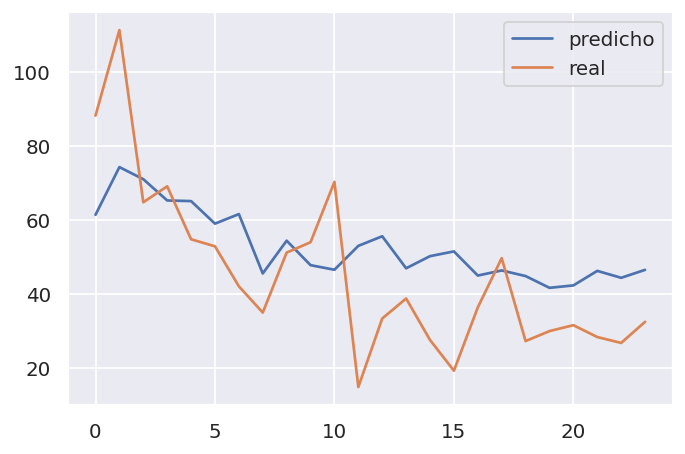

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>

* Utilice la función que definió anteriormente para facilitar la implementación, y construya de manera iterativa el arreglo con los valores predichos y las nuevas ventanas de entrada de la siguiente predicción.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>

* Inicialice un arreglo de _Numpy_ con el tamaño requerido y asigne los valores con un bucle **`for`**.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 3</b></font>
</summary>

* Utilice la función **`concatenate`** de _NumPy_  para generar una nueva ventana al concatenar los valores de la ventana previa (sin el primer valor) y el valor predicho en la última iteración. Por ejemplo:

```python
>>> np.concatenate( ([0, 1, 2], [3, 4]) )
array([0, 1, 2, 3, 4])
```


**¡Felicitaciones!** Ha terminado la tarea de la Unidad 3. ¡Buen trabajo!

## **Entrega**

Para entregar el notebook por favor haga lo siguiente:
1. Descargue el notebook (`Archivo` -> `Descargar .ipynb`).
2. Ingrese a Moodle.
3. Realice el envío del *notebook* que descargó en la tarea (o quiz) correspondiente.
4. Recuerde que si tiene algún error, puede hacer múltiples intentos de envío en UNCode.

## **Referencias**
---
- [mlcourse -
Topic 3. Classification, Decision Trees and k Nearest Neighbors
](https://mlcourse.ai/articles/topic3-dt-knn/)


## **Créditos**
---

* **Profesor:** [Fabio Augusto González](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes:**
  * Miguel Angel Ortiz Marín
  * Alberto Nicolai Romero Martínez

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*